# Imports

In [2]:
%load_ext autoreload
%autoreload 2

import skimage
import os
import glob
import importlib
import wandb
import numpy as np
import matplotlib.pyplot as plt
import egg_class_functions as ecf
import tensorflow as tf
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras

importlib.reload(ecf)

2025-07-09 11:10:28.369788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 11:10:28.528307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752052228.602444    1861 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752052228.626428    1861 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752052228.770438    1861 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

<module 'egg_class_functions' from '/home/tibor/Documents/python/mosquito-egg-identification/egg_class_functions.py'>

# Variable setup

In [3]:
seg_data_path = "Data/processed/predicted_segmentation_data.csv"
image_paths = sorted(glob.glob("Data/raw/microscope/**/*.*", recursive=True), key=lambda x: (os.path.dirname(x), os.path.basename(x)))
BATCH_SIZE = 32
EPOCHS = 100
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
df_pred = ecf.segmented_image_import(seg_data_path)
single_egg_df = df_pred.loc[df_pred["single"] == 1].reset_index(drop=True)
single_egg_df = single_egg_df.dropna()
single_egg_df["segment"] = single_egg_df.apply(ecf.rotate_and_pad_rgb_segment, axis=1)
single_egg_df['species'] = single_egg_df['species'].replace("aegypti_old", "aegypti")
single_egg_df['species'] = single_egg_df['species'].replace("albopictus_old", "albopictus")
# train, test = train_test_split(single_egg_df, test_size=0.1)

X_train = single_egg_df['segment']
X_train = np.stack(X_train.to_list()).astype(np.float32)
y_train = single_egg_df['species']
#X_test = test['segment']
#X_test = np.stack(X_test.to_list()).astype(np.float32)
#y_test = test['species']
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_onehot = to_categorical(y_train_encoded)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=42)

In [5]:
print(f"albopictus: {sum(single_egg_df['species'] == 'albopictus')}")
print(f"aegypti: {sum(single_egg_df['species'] == 'aegypti')}")

albopictus: 298
aegypti: 268


### Albumentation image augmenation

In [ ]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=(0, 0.0625), scale_limit=0.0, rotate_limit=(-5, 5), p=0.5),
    A.RandomBrightnessContrast(ensure_safe_range=True, p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomToneCurve(scale=0.05, per_channel=False, p=0.5),
    A.RandomShadow(shadow_roi=(0.3,0,0.7,1)),
])

color_trans = A.Compose([
    # Image Capture Variance
    #A.Resize(image_height, image_width, p=1),
    A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=.5),
    A.PlanckianJitter(p=.5),
    A.ImageCompression(quality_lower=75, quality_upper=100, p=.25),
    A.Defocus(radius=(1, 3), p=.25),
    A.RandomGamma(gamma_limit=(80, 120), p=.25),
    A.MotionBlur(blur_limit=(3, 3), p=.25),
    A.Downscale(scale_min=0.75, scale_max=1, p=.25),
    # Color Changes
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=.5),
    A.ChannelDropout(channel_drop_range=(1, 1), p=.25),
    A.RandomShadow(shadow_roi=(0.3,0,0.7,1),p=0.25),
    # Noise
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=.25),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=(0, 0.0625), scale_limit=0.0, rotate_limit=(-5, 5), p=0.5),
])


def albumentations_augment(image):
    image = image.astype(np.uint8)
    augmented = color_trans(image=image)
    aug_image = augmented['image'].astype(np.float32)
    return aug_image


def tf_albumentations_augment(image, label):
    aug_image = tf.numpy_function(albumentations_augment, [image], tf.float32)
    aug_image.set_shape(image.shape)
    return aug_image, label

train_ds = ecf.prepare_dataset_alb(X_train_split, y_train_split, tf_albumentations_augment, BATCH_SIZE)
val_ds = ecf.prepare_dataset_alb(X_val_split, y_val_split, None, BATCH_SIZE, shuffle=False)

/tmp/ipykernel_1861/516118102.py:16: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, quality_upper=100, p=.25),
/tmp/ipykernel_1861/516118102.py:20: UserWarning: Argument(s) 'scale_min, scale_max' are not valid for transform Downscale
  A.Downscale(scale_min=0.75, scale_max=1, p=.25),


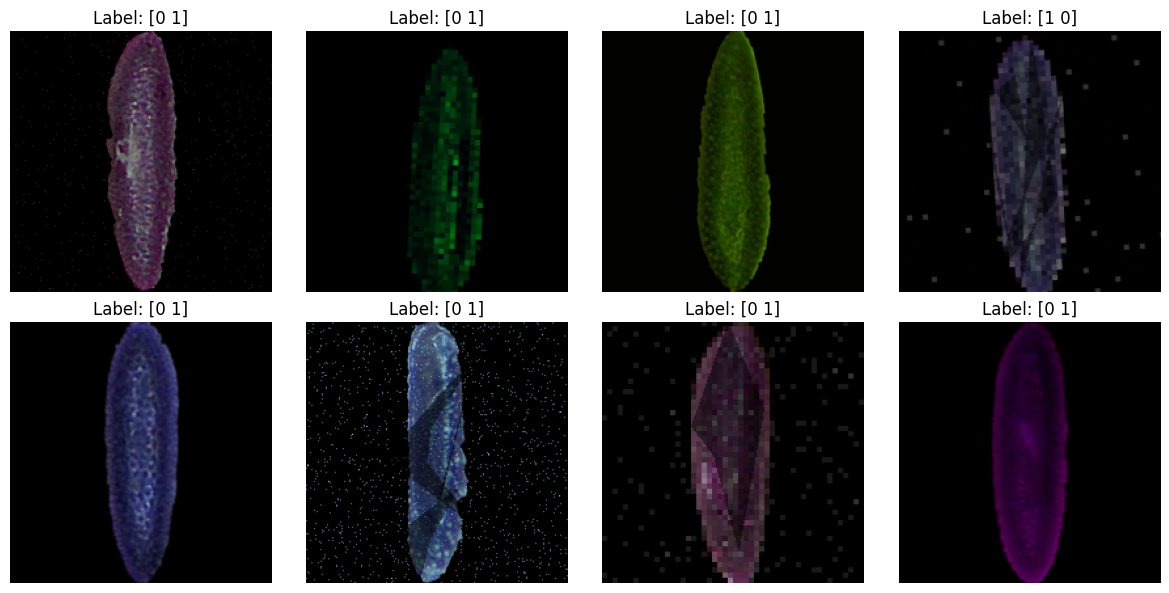

In [38]:
# Einen Batch extrahieren
for images, labels in train_ds.take(1):
    images = images.numpy()
    labels = labels.numpy()

    # Zeige einige Bilder
    plt.figure(figsize=(12, 6))
    for i in range(min(8, len(images))):  # max 8 Bilder anzeigen
        plt.subplot(2, 4, i+1)
        img = images[i]
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

### Tensorflow image augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.0277),
  layers.RandomBrightness(factor=0.2),
  layers.RandomContrast(factor=0.2),
  #layers.RandomColorJitter(
  #    value_range=(0, 1),
  #    brightness_factor=0.2,
  #    contrast_factor=0.2,
  #    saturation_factor=0.5,
  #    hue_factor=(0.5, 0.5)
  #    ),
  #layers.RandomColorDegeneration(0.2),
  #layers.RandomHue(factor=(0.5, 0.5), value_range=(0, 1)),
  #layers.RandomSaturation(factor=0.5, value_range=(0, 1)),
  #layers.RandomGaussianBlur(factor=0.2, sigma=(0.1, 0.4), value_range=(0, 1)),

])

train_ds = ecf.prepare_dataset_tf(X_train_split, y_train_split, data_augmentation, BATCH_SIZE)
val_ds = ecf.prepare_dataset_tf(X_val_split, y_val_split, None, BATCH_SIZE, shuffle=False)

2025-07-09 10:29:30.096656: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


# Model Training

In [7]:
weight_for_albo = (1 / sum(single_egg_df['species'] == 'albopictus')) * (len(single_egg_df))
weight_for_aegy = (1 / sum(single_egg_df['species'] == 'aegypti')) * (len(single_egg_df))

class_weight = {0: weight_for_albo, 1: weight_for_aegy}

In [7]:
print('Weight for class 0: {:.2f}'.format(weight_for_albo))
print('Weight for class 1: {:.2f}'.format(weight_for_aegy))

Weight for class 0: 1.90
Weight for class 1: 2.11


In [12]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(200, 200, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(rate=0.25),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [15]:
model.trainable = True

In [16]:
wandb.init(project="egg-classification", config={
    "architecture": "EfficientNetV2B0",
    "input_shape": (200, 200, 3),
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "optimizer": "adam",
    "loss": "categorical_crossentropy",
    "num_classes": 2
})


local_checkpoint = ModelCheckpoint(
    filepath="models/model.{epoch:02d}.h5",
    save_best_only=True,
    save_weights_only=False
)

#wandb_checkpoint = WandbModelCheckpoint(
#    filepath="models-wandb/model-{epoch:02d}.keras",
#    save_best_only=True
#)

optimizer = keras.optimizers.Adam(learning_rate=0.000005)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[WandbMetricsLogger(),
                               #wandb_checkpoint                               
                                ],
                    #class_weight=class_weight
                    )

y_true = []
y_pred = []

for x, y in val_ds:
    preds = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
    probs=None,
    y_true=y_true,
    preds=y_pred,
    class_names=["aegypti", "albopictus"]
)})

wandb.finish()

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 671ms/step - accuracy: 0.7818 - loss: 0.4788 - val_accuracy: 0.7368 - val_loss: 0.5336
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8024 - loss: 0.4658 - val_accuracy: 0.6754 - val_loss: 0.5608
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7903 - loss: 0.4721 - val_accuracy: 0.6842 - val_loss: 0.6083
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7885 - loss: 0.4359 - val_accuracy: 0.7544 - val_loss: 0.5587
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7617 - loss: 0.5026 - val_accuracy: 0.7368 - val_loss: 0.5984
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7924 - loss: 0.4808 - val_accuracy: 0.7544 - val_loss: 0.5633
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7783 - loss: 0.4566 - val_accuracy: 0.7632 - val_loss: 0.5338
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7811 - loss: 0.5128 - val_accuracy: 

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch/accuracy,▇▁▄█▆█▇▂▃▆▃▃▅▇▂▂▂▃▆▆▂▃▃▃▂▃▅█▅▃▅▄▆▃▄▇▄▁▄▃
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▄▅▄▄▄█▆▃▇▃▇▃▄▅▆▇▃▄▃▃▃▄▃▅▅▅▁▂▄▄▄▆▄▄▂▃▄▆▅▅
epoch/val_accuracy,▅▆▆▇▃▅▆▅▁▇▃▂▄▅▄█▂▃▅▆▅▇▅▆▅▅▅▅▆▇▄▅▃▃▃▅▆▄▁▃
epoch/val_loss,▄▄▇▂▄▁▄▅▃▆▅▄▆█▃▄▂▇▃▄▂▃▄▄▅▄▄▃▅▃▁▆▄▇▃▅▄▅▂▆
epoch/accuracy,0.75885
epoch/epoch,99
epoch/learning_rate,0.0
epoch/loss,0.47522
epoch/val_accuracy,0.71053
